# Import Library

In [37]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

# Load Data

In [38]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
cats = pd.read_csv('data/item_categories.csv')
train = pd.read_csv('data/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('data/test.csv').set_index('ID')

# Explore data analysis
## Outlier

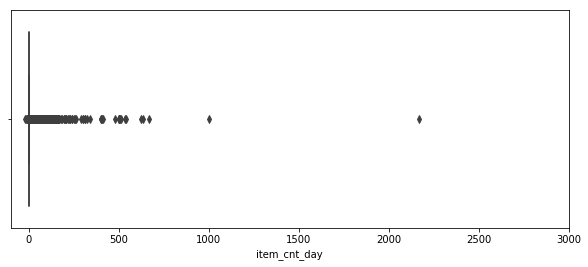

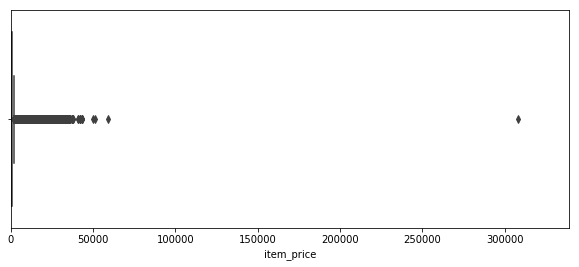

In [39]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

# Remove outlier

In [40]:
train = train[train.item_price<50000]
train = train[train.item_cnt_day<1001]

# Missing value completion

In [41]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

# Lemmatization

In [42]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# Create Feature
## city, city code from shop data
## category type, subtype from item category

In [43]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

# Confirm the difference between test data and train data and size of data.

In [44]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

# Make the matrix which join with test and train
# Downcast the data

In [45]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

17.83122992515564

# Add the revenue

In [46]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

# Sum monthly item count and clip

In [47]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

7.076397180557251

# Add date block num
# Downcasting

In [48]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

# Make the matrix for test set and fillna

In [49]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.18356990814208984

# Join the created feature and downcasting

In [50]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

6.845172882080078

# Create function for lag feature

In [51]:
def base_lag_feature(df, lags, col):
        tmp = df[['date_block_num','shop_id','item_id',col]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
            shifted['date_block_num'] += i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        return df

def add_grouped_feature(matrix, grpcol, aggcol, method, featurename, lag):

    def lag_feature(df, lags, col):
        tmp = df[['date_block_num','shop_id','item_id',col]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
            shifted['date_block_num'] += i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        return df

    group = matrix.groupby(grpcol).agg({aggcol: method})
    group.columns = [featurename]
    group.reset_index(inplace=True)
    matrix = pd.merge(matrix, group, on=grpcol, how='left')
    matrix[featurename] = matrix[featurename].astype(np.float16)
    matrix = lag_feature(matrix, lag, featurename)
    matrix.drop(featurename, axis=1, inplace=True)

    return matrix

In [52]:
ts = time.time()
matrix = base_lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

53.49255704879761

In [53]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num'], 'item_cnt_month', 'mean', "date_avg_item_cnt",  [1])
time.time() - ts

14.466567039489746

In [54]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'item_id'], 'item_cnt_month', 'mean', "date_item_avg_item_cnt",  [1,2,3,6,12])
time.time() - ts

57.02786612510681

In [55]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'shop_id'], 'item_cnt_month', 'mean', "date_shop_avg_item_cnt",  [1,2,3,6,12])
time.time() - ts

58.157198905944824

In [56]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'mean', "date_cat_avg_item_cnt",  [1])
time.time() - ts

21.03212285041809

In [57]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'mean', "date_shop_cat_avg_item_cnt",  [1])
time.time() - ts

22.214483976364136

In [58]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'shop_id', 'type_code'], 'item_cnt_month', 'mean', "date_shop_type_avg_item_cnt",  [1])
time.time() - ts

22.543922901153564

In [59]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'city_code'], 'item_cnt_month', 'mean', "date_city_avg_item_cnt",  [1])
time.time() - ts

29.973979949951172

In [60]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'item_id', 'city_code'], 'item_cnt_month', 'mean', "date_item_city_avg_item_cnt",  [1])
time.time() - ts

40.94778800010681

In [61]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'type_code'], 'item_cnt_month', 'mean', "date_type_avg_item_cnt",  [1])
time.time() - ts

27.490013122558594

In [62]:
ts = time.time()
matrix = add_grouped_feature(matrix, ['date_block_num', 'subtype_code'], 'item_cnt_month', 'mean', "date_subtype_avg_item_cnt",  [1])
time.time() - ts

24.186468839645386

In [63]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = base_lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

488.18388986587524

In [64]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = base_lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

31.226124048233032

In [65]:
matrix['month'] = matrix['date_block_num'] % 12

In [66]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [67]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

1383.9357130527496

In [68]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

857.5336439609528

In [69]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

4.286374092102051

In [70]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

2.0479490756988525

In [71]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

6.925814151763916

In [72]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'month', 'days', 'item_shop_la

In [73]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639246 entries, 4488710 to 11127955
Data columns (total 39 columns):
date_block_num                       int8
shop_id                              int8
item_id                              int16
item_cnt_month                       float16
city_code                            int8
item_category_id                     int8
type_code                            int8
subtype_code                         int8
item_cnt_month_lag_1                 float16
item_cnt_month_lag_2                 float16
item_cnt_month_lag_3                 float16
item_cnt_month_lag_6                 float16
item_cnt_month_lag_12                float16
date_avg_item_cnt_lag_1              float16
date_item_avg_item_cnt_lag_1         float16
date_item_avg_item_cnt_lag_2         float16
date_item_avg_item_cnt_lag_3         float16
date_item_avg_item_cnt_lag_6         float16
date_item_avg_item_cnt_lag_12        float16
date_shop_avg_item_cnt_lag_1         float16


In [74]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [75]:
data = pd.read_pickle('data.pkl')

In [76]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    # 'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [77]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [78]:
del data
gc.collect();

In [79]:
ts = time.time()

model = XGBRegressor(
    max_depth=9,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=1)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[00:25:55] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.14971	validation_1-rmse:1.11643
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10163	validation_1-rmse:1.07993
[2]	validation_0-rmse:1.06022	validation_1-rmse:1.04939
[3]	validation_0-rmse:1.02477	validation_1-rmse:1.02401
[4]	validation_0-rmse:0.994653	validation_1-rmse:1.002
[5]	validation_0-rmse:0.969238	validation_1-rmse:0.984023
[6]	validation_0-rmse:0.946957	validation_1-rmse:0.968716
[7]	validation_0-rmse:0.928733	validation_1-rmse:0.956426
[8]	validation_0-rmse:0.913276	validation_1-rmse:0.946422
[9]	validation_0-rmse:0.900071	validation_1-rmse:0.938665
[10]	validation_0-rmse:0.888844	validation_1-rmse:0.932457
[11]	validation_0-rmse:0.879229	validatio

1297.1083388328552

In [80]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

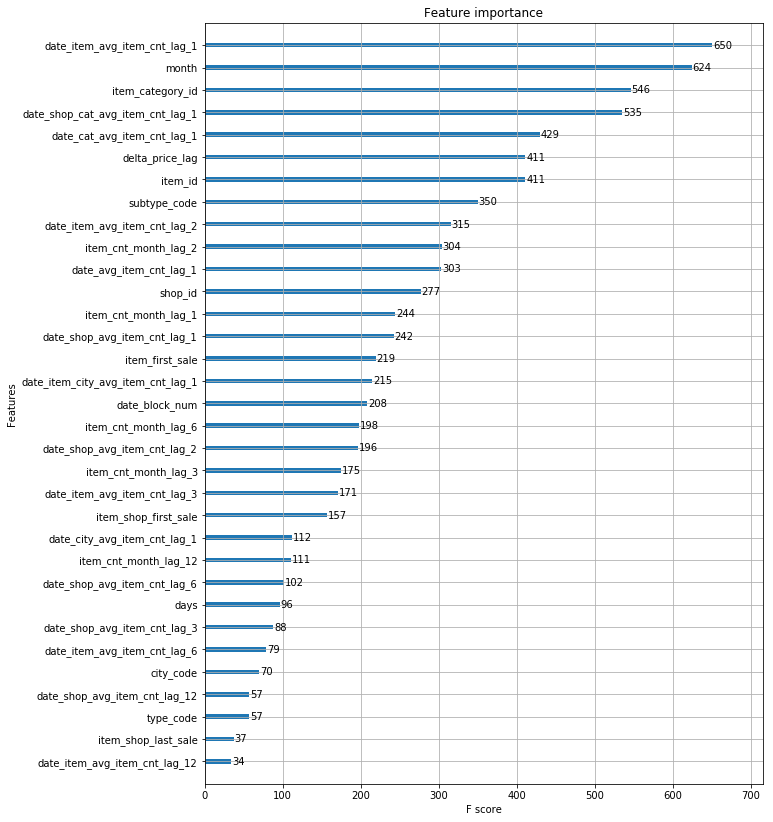

In [81]:
plot_features(model, (10,14))